## cDCGAN for Ising model dataset
In this notebook I create a conditional deep convolutional GAN to generate Ising model configurations at specific temperatures. The generator and discriminator are constructed using the tf.keras Functional API


In [1]:
import tensorflow as tf


%matplotlib inline
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow import keras
import glob
import imageio
import PIL
import time

from IPython import display

## Load data
For a GAN, we don't need a validation set, only load the training set.

The labels for the configurations are now the actual temperatures used in the Monte Carlo simulations. I am using configurations from a 40x40 spin Ising system.

For the temerature labels, I round to the nearest 10th degree. For example: 2.25 --> 2.3

Then, I assign an interger value to each temperature, starting with 0 for the lowest temp.

In [2]:
def one_hot_label(img):
    # img is the file name of a configuration
    label, T, _, = img.split('_')
    if label == 'low':
        ohl = np.array([1, 0])
    elif label == 'high':
        ohl = np.array([0, 1])
    return ohl, np.round((float(T)-1.5)/0.1)

def data_with_label(data_path, *args):
    data = []
    if args:  # The args are the categories in the data path that separate the classes/categories
        for category in args:
            category_path = os.path.join(data_path, category)  # Category folder
            for i in tqdm(os.listdir(category_path)):
                path = os.path.join(category_path, i)
                img = np.load(path)  # Assuming the files are NumPy arrays
                data.append([img.astype(dtype='float32'), one_hot_label(i)])
        shuffle(data)
    return data

In [ ]:
!pip install intel_extension_for

In [3]:
!unzip -q /content/train.zip -d /content/

train_path = '/content/train'

In [4]:
train_set=data_with_label(train_path,'low','high')

100%|██████████| 8000/8000 [00:01<00:00, 4121.63it/s]


In [ ]:
def one_hot_label(img):
    # img is the file name of a configuration
    label, T, _, = img.split('_')
    if label == 'low':
        ohl = np.array([1, 0])
    elif label == 'high':
        ohl = np.array([0, 1])
    return ohl, np.round((float(T)-1.5)/0.1)

def data_with_label(data_path, *args):
    data = []
    if args:  # The args are the categories in the data path that separate the classes/categories
        for category in args:
            category_path = os.path.join(data_path, category)  # Category folder
            for i in tqdm(os.listdir(category_path)):
                path = os.path.join(category_path, i)
                img = np.load(path)  # Assuming the files are NumPy arrays
                data.append([img.astype(dtype='float32'), one_hot_label(i)])
        shuffle(data)
    return data

train_set=data_with_label(train_path,'low','high')

tr_img_data = np.array([i[0] for i in train_set]).reshape(-1,20,20,1)
tr_img_data_float = tr_img_data.astype(dtype='float32')

tr_lbl_data = np.array([i[1][1] for i in train_set])

print(len(np.unique(tr_lbl_data)))

train_labels_emb = tf.keras.utils.to_categorical(tr_lbl_data, 17)
BUFFER_SIZE = 15000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((tr_img_data_float,train_labels_emb)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

I like the keras.to_categotical utility. So, to use it here,
I determine how many unique temperature were used in the simulations and create a one-hot encoding for each.

In [10]:
BUFFER_SIZE = 15000
BATCH_SIZE = 128

Create a tensorflow dataset object that acts as a pipeline for feeding data to the model.

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((tr_img_data_float,train_labels_emb)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Define the generator
I use the tf.keras Functional API to define a net that takes as input a random noise vector of length 100, and a one-hot encoding of the temperature. Then, an embedding is greated from the temperature label and concatenated with the first fully connected layer from the noise input.

Then, there are 3 Transverse Convolutional layers, the latter two of which upscale the previous layer output.
The final output is a 40x40 tensor, the same dimensions as the Ising array I am training against.

In [ ]:
def make_generator_model():
    # Input is x (noise) and y (label)
    # Input x
    input_x = tf.keras.layers.Input(shape=(100,), name='noise_input')
    x = tf.keras.layers.Dense(10*10*256,use_bias=False)(input_x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    reshape_x = tf.keras.layers.Reshape((10, 10, 256))(x)

    # Input y
    input_y = tf.keras.layers.Input(shape=(17,), name='label_input')
    y = tf.keras.layers.Dense(10*10*128,use_bias=False)(input_y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.LeakyReLU()(y)

    reshape_y = tf.keras.layers.Reshape((10, 10, 128))(y)

    # Combine Inputs
    xy = tf.keras.layers.concatenate([reshape_x, reshape_y])

    # First Transpose Conv layer (no upscale)
    xy = tf.keras.layers.Conv2DTranspose(128,(5,5),strides=(1, 1), padding='same', use_bias=False)(xy)
    xy = tf.keras.layers.BatchNormalization()(xy)
    xy = tf.keras.layers.LeakyReLU()(xy)

    # Second Transpose Conv layer (upscale)
    xy = tf.keras.layers.Conv2DTranspose(64,(5,5),strides=(2, 2), padding='same', use_bias=False)(xy)
    xy = tf.keras.layers.BatchNormalization()(xy)
    xy = tf.keras.layers.LeakyReLU()(xy)

    # Third Transpose Conv layer (upscale)
    xy_final = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(xy)

    model = tf.keras.Model(inputs=[input_x, input_y], outputs=xy_final)
    
    return model

In [1]:
import gan as gan

In [1]:
import dataset as ds

from torch.utils.data import Dataset, DataLoader
data_path = r'C:\Users\frenc\Documents\dottorato\ising\train'  # Update with actual path
categories = ['low', 'high']
buffer_size = 15000
batch_size = 128
num_classes = 17

dataset_ = ds.CustomDataset(data_path, categories,num_classes=17)
train_loader = DataLoader(dataset_, batch_size=batch_size, shuffle=True)

100%|██████████| 8000/8000 [00:02<00:00, 3210.64it/s]


In [2]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([128, 1, 20, 20]) torch.Size([128, 17])


In [9]:
import torch
noise = torch.randn(16, 100)  # Batch of 16 noise samples
y_labels = torch.randn(16, 17)  # Batch of 16 label samples
generator = gan.Generator(output_height = 20, output_width =  20)
out = generator(noise, y_labels)
print(out.shape)  # Expected shape: (16, 1, 20, 20)

torch.Size([16, 1, 20, 20])


In [10]:
img = torch.randn(8, 1, 20, 20)  # Batch of 8 images (grayscale, 20x20)
labels = torch.randn(16, 17)       # Batch of 8 labels (17-dimensional)
discriminator = gan.Discriminator(input_height=20, input_width=20)
out = discriminator(out, labels)
print(out.shape)  # Expected output: (8, 1)

torch.Size([16, 1])


## Define the Discriminator
This net takes a 40x40 configuration input and the one-hot temperature label.

The Configuration input is passed through two convolutional layers and the label input is passed through two fully connected layers. Then, they are combined and passed through a fully connected layer to the output layer.

I made this Discriminator "weak" by only allowing 16 filter for the first conv layer, and 32 for the second. This helps prevent the discriminator from overpowering the generator.

In [35]:
def make_discriminator_model():

    # Input is x (noise) and y (label)
    # First Conv layer
    input_x = tf.keras.layers.Input(shape=(20,20,1), name='image_input')
    x = tf.keras.layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same')(input_x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Second Conv layer
    x = tf.keras.layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    #reshape_x = tf.keras.layers.Reshape((7, 7, 256))(x)

    input_y = tf.keras.layers.Input(shape=(17,), name='label_input')
    y = tf.keras.layers.Dense(1024)(input_y)
    y = tf.keras.layers.LeakyReLU()(y)

    y = tf.keras.layers.Dense(10*10*128)(y)
    y = tf.keras.layers.LeakyReLU()(y)
    y = tf.keras.layers.BatchNormalization()(y)

    reshape_y = tf.keras.layers.Reshape((10, 10, 128))(y)

    xy = tf.keras.layers.concatenate([x, reshape_y])

    xy = tf.keras.layers.Flatten()(xy)
    xy = tf.keras.layers.Dense(1024)(xy)
    xy = tf.keras.layers.LeakyReLU()(xy)

    xy_final = tf.keras.layers.Dense(1)(xy)
    #xy_final = tf.keras.layers.Si

    model = tf.keras.Model(inputs=[input_x, input_y], outputs=xy_final)

    return model

In [36]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [15]:
import tensorflow as tf

# Define Binary Cross Entropy loss with logits
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(generated_output):
    # The generator wants the discriminator to classify its output as real (1s)
    return bce(tf.ones_like(generated_output), generated_output)


In [16]:
import tensorflow as tf

# Define Binary Cross Entropy loss with logits
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, generated_output):
    # Real images should be classified as 1 (real)
    real_loss = bce(tf.ones_like(real_output), real_output)

    # Generated (fake) images should be classified as 0 (fake)
    generated_loss = bce(tf.zeros_like(generated_output), generated_output)

    total_loss = real_loss + generated_loss
    return total_loss

In [17]:
import tensorflow as tf

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


In [18]:
checkpoint_dir = './training_checkpoints_cGAN'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Now, set up a random noise vector to monitor the performance as the GAN trains. The labels attached to the noise vector start from the lowest temperature and increase.

In [19]:
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])
tmpList=np.arange(16)

labels_for_generation = tf.keras.utils.to_categorical(tmpList,17)


In [3]:
import torch
import numpy as np
import torch.nn.functional as F

noise_dim = 100
num_examples_to_generate = 16

# Generate a random vector using a normal distribution
random_vector_for_generation = torch.randn(num_examples_to_generate, noise_dim)

tmpList = torch.arange(16)

# Create one-hot encoded labels with 17 classes
labels_for_generation = F.one_hot(tmpList, num_classes=17).float()

# Print shapes to verify
print(random_vector_for_generation.shape)  # Should be (16, 100)
print(labels_for_generation.shape)

torch.Size([16, 100])
torch.Size([16, 17])


In [20]:
def train_step(images,labels,gen_loss_log,disc_loss_log):
   # generating noise from a normal distribution
      current_batch_size = tf.shape(labels)[0]
      noise = tf.random.normal([current_batch_size, noise_dim])

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise,labels], training=True)

        real_output = discriminator([images,labels], training=True)
        generated_output = discriminator([generated_images,labels], training=True)

        gen_loss = generator_loss(generated_output)
        gen_loss_log.append(gen_loss)
        disc_loss = discriminator_loss(real_output, generated_output)
        disc_loss_log.append(disc_loss)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [ ]:
#train_step = tf.contrib.eager.defun(train_step)

In [43]:
from tqdm import tqdm
def train(dataset, epochs,gen_loss_log,disc_loss_log):
  for epoch in range(epochs):
    start = time.time()

    for batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{epochs}"):
      images = batch[0]
      lbls = batch[1]
      train_step(images,lbls,gen_loss_log,disc_loss_log)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation,labels_for_generation)

    # saving (checkpoint) the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
    #generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation,labels_for_generation)


Define a helper function to plot and save images.

In [41]:
def generate_and_save_images(model, epoch, test_input_noise,test_input_labels):
    #predictions = model([test_input_noise,test_input_labels], training=False)
    predictions = tf.round(model([test_input_noise,tf.convert_to_tensor(test_input_labels, dtype=tf.float32)], training=False))

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train the cDCGAN!

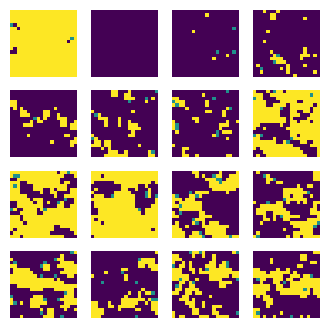

Epoch 124/150:  55%|█████▌    | 65/118 [00:21<00:20,  2.58it/s]Exception ignored in: <generator object tqdm.__iter__ at 0x7db2221bed60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1196, in __iter__
    self.close()
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1265, in close
    def close(self):

KeyboardInterrupt: 
Epoch 124/150:  55%|█████▌    | 65/118 [00:40<00:33,  1.59it/s]


KeyboardInterrupt: 

In [44]:
%%time
EPOCHS = 150
gen_loss_log = []
disc_loss_log = []
train(train_dataset,
      EPOCHS,
      gen_loss_log,
      disc_loss_log)

### Plot generator and discriminator loss over training

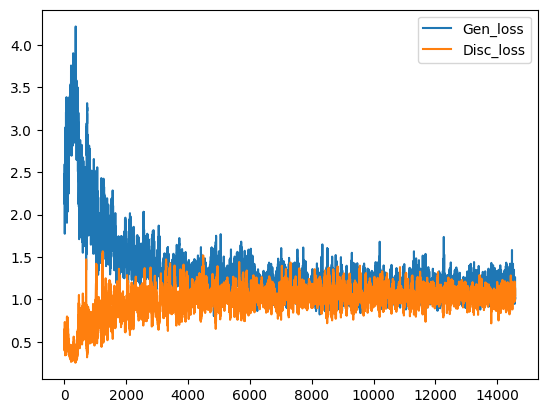

In [45]:
plt.plot(np.asarray(gen_loss_log),label="Gen_loss")
plt.plot(np.asarray(disc_loss_log),label="Disc_loss")
plt.legend(loc='upper right')

In [46]:
np.save('GeneratorLoss_cGAN.npy',np.asarray(gen_loss_log))
np.save('DiscriminatorLoss_cGAN.npy',np.asarray(disc_loss_log))

# Performance
## Generated Output

After training the GAN for ~150 epochs we arrive at some nice looking results!
Below I plot the generator output for an array of temperatures, starting from low going to high. We see the generator has captured the correct trend. At low T, most of the spins are aligned. As T increases more clusters of alighned spins form and for the highest T we have reduced correlation between neighboring spins.

In [52]:
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])
tmpList=np.arange(16)

labels_for_generation = tf.keras.utils.to_categorical(tmpList,17)

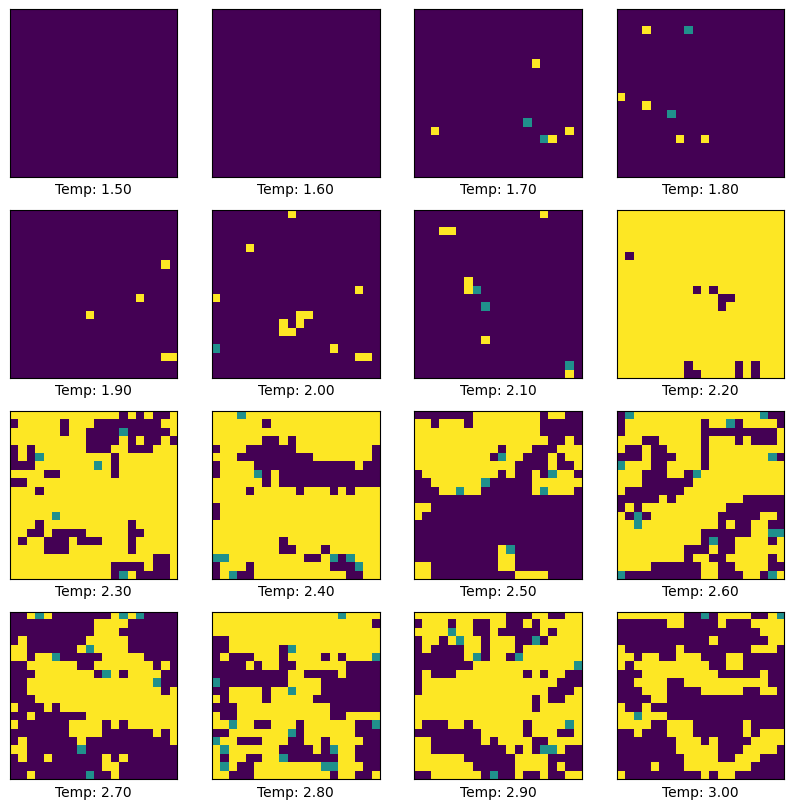

In [53]:
predictions = tf.round(generator([random_vector_for_generation,tf.convert_to_tensor(labels_for_generation, dtype=tf.float32)], training=False))

fig = plt.figure(figsize=(10,10))

for i in range(num_examples_to_generate):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predictions[i, :, :, 0])
    #plt.axis('off')
    temp = 1.5+i*0.1
    plt.xlabel(f'Temp: {temp:.2f}')

#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()

In [118]:
noise_dim = 100
num_examples_to_generate = 17*100

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])
tmpList=np.ravel([np.arange(17)]* 100)

labels_for_generation = tf.keras.utils.to_categorical(tmpList,17)
predictions = tf.round(generator([random_vector_for_generation,tf.convert_to_tensor(labels_for_generation, dtype=tf.float32)], training=False))

labels_for_generation.shape

(1700, 17)

In [112]:
import numpy as np
def Spin_Correlation_Op(Lattice,L):
    Spin_corr = np.zeros(int(L/2)+1);
    x0 = int(L/2)-1; y0 = int(L/2)-1;
    for i in range(int(L/2)+1):
        Spin_corr[i] = 0.25*Lattice[x0,y0]*( Lattice[x0+i,y0] + Lattice[x0-i,y0] + Lattice[x0,y0+i] + Lattice[x0,y0-i])
    return Spin_corr
import numpy as np

def calculate_spin_correlations(states, L=20, num_temps=17):
    """
    Calculate spin-spin correlations for multiple Ising states at different temperatures

    Parameters:
    states: tensor/array of shape [N, L, L] containing the Ising states
    L: size of the lattice (default 20)
    num_temps: number of different temperatures (default 17)

    Returns:
    correlations: array of shape [num_temps, L/2 + 1] containing averaged correlations for each temperature
    """
    # Reshape states if needed
    states = states.numpy() if hasattr(states, 'numpy') else states
    states = states.reshape(-1, L, L)

    # Initialize array to store correlations
    correlations = np.zeros((num_temps, int(L/2) + 1))

    # Calculate correlations for each temperature
    for temp in range(num_temps):
        # Get samples for current temperature using the provided indexing
        temp_samples = states[temp * 100:(temp + 1) * 100]

        # Calculate average correlation for this temperature
        temp_correlations = np.zeros((len(temp_samples), int(L/2) + 1))
        for i, lattice in enumerate(temp_samples):
            temp_correlations[i] = Spin_Correlation_Op(lattice, L)

        correlations[temp] = np.mean(temp_correlations, axis=0)

    return correlations

# Calculate correlations for generated predictions
pred_correlations = calculate_spin_correlations(predictions, L=20, num_temps=17)

# Calculate correlations for true images
true_correlations = np.zeros((17, int(20/2) + 1))
for i in range(17):
    # Get images for current temperature
    images_temp = tr_img_data[np.where(tr_lbl_data==i)[0], :, :, 0]
    # Calculate correlations for this temperature
    true_correlations[i] = calculate_spin_correlations(images_temp, L=20, num_temps=1)[0]

# Now you have:
# - pred_correlations: shape [17, 11] for generated states
# - true_correlations: shape [17, 11] for true states


true_correlations.shape

(17, 11)

In [129]:
tmpList

array([ 0,  1,  2, ..., 14, 15, 16])

In [147]:
np.where(tmpList==16)

array([  16,   33,   50,   67,   84,  101,  118,  135,  152,  169,  186,
        203,  220,  237,  254,  271,  288,  305,  322,  339,  356,  373,
        390,  407,  424,  441,  458,  475,  492,  509,  526,  543,  560,
        577,  594,  611,  628,  645,  662,  679,  696,  713,  730,  747,
        764,  781,  798,  815,  832,  849,  866,  883,  900,  917,  934,
        951,  968,  985, 1002, 1019, 1036, 1053, 1070, 1087, 1104, 1121,
       1138, 1155, 1172, 1189, 1206, 1223, 1240, 1257, 1274, 1291, 1308,
       1325, 1342, 1359, 1376, 1393, 1410, 1427, 1444, 1461, 1478, 1495,
       1512, 1529, 1546, 1563, 1580, 1597, 1614, 1631, 1648, 1665, 1682,
       1699])

In [157]:
import numpy as np
def Spin_Correlation_NN_Op(Lattice,L):
    Spin_corr_nn = 0
    for x in range(L):
        for y in range(L):
            # nearest neighbors are (x,y1)(x,y2)(x1,y)(x2,y)
            x1,x2,y1,y2=(x-1)%L,(x+1)%L,(y-1)%L,(y+1)%L;
            Spin_corr_nn += 0.25*Lattice[x,y]*(Lattice[x,y1]+Lattice[x,y2]+Lattice[x1,y]+Lattice[x2,y]);
    return Spin_corr_nn/L**2
import numpy as np

def calculate_spin_correlations(states,temps, L=20, num_temps=17):
    """
    Calculate spin-spin correlations for multiple Ising states at different temperatures

    Parameters:
    states: tensor/array of shape [N, L, L] containing the Ising states
    L: size of the lattice (default 20)
    num_temps: number of different temperatures (default 17)

    Returns:
    correlations: array of shape [num_temps, L/2 + 1] containing averaged correlations for each temperature
    """
    states = states.reshape((states.shape[:3]))

    # Reshape states if needed
    states = states.numpy() if hasattr(states, 'numpy') else states
    states = states.reshape(-1, L, L)

    # Initialize array to store correlations
    correlations = np.zeros((num_temps))

    # Calculate correlations for each temperature
    for temp in range(num_temps):

        # Get samples for current temperature using the provided indexing
        result = states[np.where(temps==temp)[0],:,:]

        temp_samples = result

        # Calculate average correlation for this temperature
        temp_correlations = np.zeros((len(temp_samples)))
        for i, lattice in enumerate(temp_samples):
            temp_correlations[i] = Spin_Correlation_NN_Op(lattice, L)

        correlations[temp] = np.mean(temp_correlations, axis=0)

    return correlations

# Calculate correlations for generated predictions
pred_correlations = calculate_spin_correlations(predictions_np,tmpList, L=20, num_temps=17)

# # Calculate correlations for true images
true_correlations = np.zeros((17))
true_correlations = calculate_spin_correlations(tr_img_data[:,:,:,0],tr_lbl_data, L= 20, num_temps=17)
# for i in range(17):
#     # Get images for current temperature
#     images_temp = tr_img_data[np.where(tr_lbl_data==i)[0], :, :, 0]
#     # Calculate correlations for this temperature
#     true_correlations[i] = calculate_spin_correlations(images_temp, L=20, num_temps=1)

# Now you have:
# - pred_correlations: shape [17, 11] for generated states
# - true_correlations: shape [17, 11] for true states



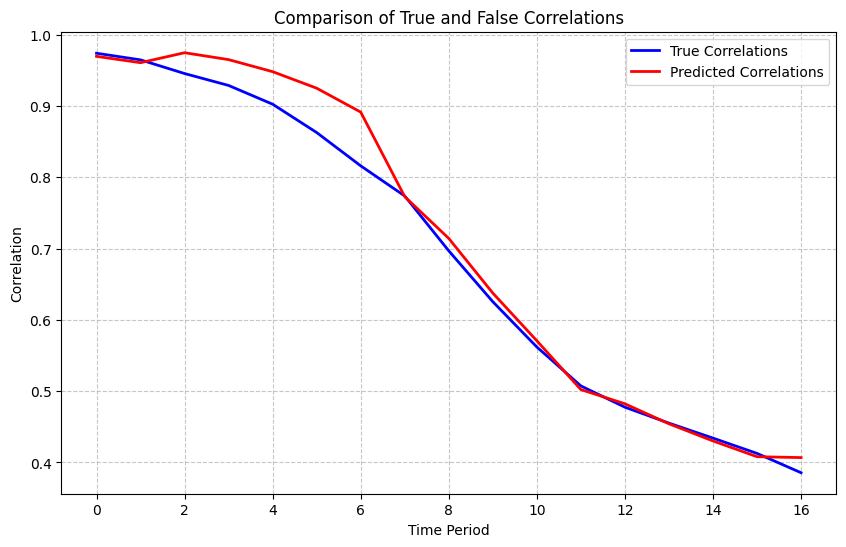

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x = np.arange(17)



# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, true_correlations, 'b-', label='True Correlations', linewidth=2)
plt.plot(x, pred_correlations, 'r-', label='Predicted Correlations', linewidth=2)

# Customize the plot
plt.xlabel('Time Period')
plt.ylabel('Correlation')
plt.title('Comparison of True and False Correlations')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()

In [ ]:
import numpy as np

def calculate_energy(mat, L):
    """
    Calculate the energy of the Ising model grid `mat` of size L x L.
    mat: Ising configuration grid with spins (+1 or -1)
    L: Size of the grid (L x L)
    """
    energy = 0.0
    for i in range(L):
        for j in range(L):
            spin = mat[i, j]
            neighbors_sum = (mat[(i+1)%L, j] + mat[(i-1)%L, j] +
                             mat[i, (j+1)%L] + mat[i, (j-1)%L])
            energy -= spin * neighbors_sum

    return energy / (2.0 * L * L)  # Factor of 2 corrects for double counting


predictions_np = np.round(predictions.numpy())

energy_values = []

# Calculate energy for each grid
for mat in predictions_np:
    energy = calculate_energy(mat, 20)
    energy_values.append(energy)

energy_values = np.array(energy_values)
print(energy_values.shape)
mean_values = np.zeros(17) # plot
import numpy as np

def calculate_means(energy_values):
    # Convert input to numpy array if it isn't already
    energy_array = np.array(energy_values)

    # Calculate how many complete groups of 17 we have
    n_complete_groups = len(energy_array) // 17

    # Reshape the array to handle complete groups
    # -1 tells numpy to calculate the appropriate number of rows
    reshaped_values = energy_array[:n_complete_groups * 17].reshape(-1, 17)

    # Calculate means along the vertical axis (axis=0)
    mean_values = np.mean(reshaped_values, axis=0)

    return mean_values

mean_values_real = calculate_means(energy_values)
print(mean_values_real)
print(mean_values_real)
true_mean_energies = [] # plot
for i in range(17):
  images_temp = tr_img_data[np.where(tr_lbl_data==i)[0], :, :, 0]
  true_mean_energies.append(np.mean([calculate_energy(mat, 20) for mat in images_temp]))


plt.plot(np.arange(17), mean_values_real, 'bo-', label="Mean Energies from Predictions")
# Plot the true mean energies for each class
plt.plot(np.arange(17), true_mean_energies, 'ro-', label="True Mean Energies for Each Class")

# Labels and title
plt.xlabel('Class (0 to 16)')
plt.ylabel('Energy')
plt.title('Comparison of Mean Energies for Each Class')
plt.legend()

# Show the plot
plt.show()



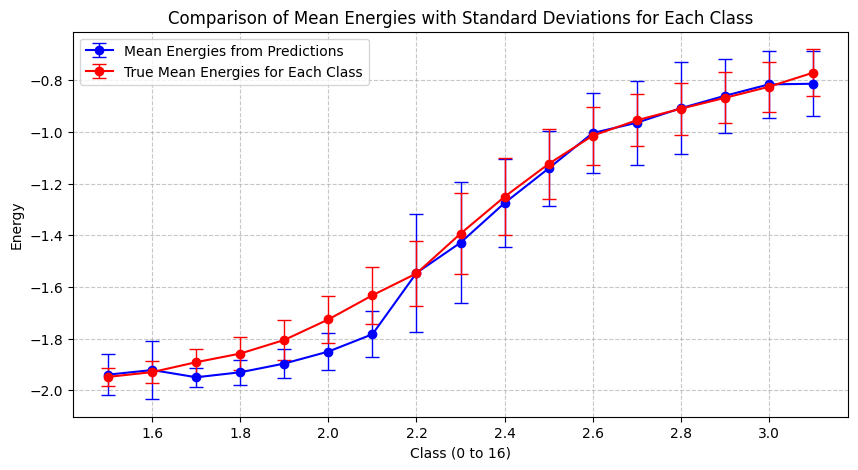

In [92]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_means_and_stds(energy_values):
    energy_array = np.array(energy_values)
    n_complete_groups = len(energy_array) // 17
    reshaped_values = energy_array[:n_complete_groups * 17].reshape(-1, 17)

    # Calculate both means and standard deviations
    mean_values = np.mean(reshaped_values, axis=0)
    std_values = np.std(reshaped_values, axis=0)

    return mean_values, std_values

# Calculate means and standard deviations for predictions
mean_values_real, std_values_real = calculate_means_and_stds(energy_values)

# Calculate means and standard deviations for true values
true_mean_energies = []
true_std_energies = []

for i in range(17):
    images_temp = tr_img_data[np.where(tr_lbl_data==i)[0], :, :, 0]
    energies = [calculate_energy(mat, 20) for mat in images_temp]
    true_mean_energies.append(np.mean(energies))
    true_std_energies.append(np.std(energies))

# Convert to numpy arrays
true_mean_energies = np.array(true_mean_energies)
true_std_energies = np.array(true_std_energies)

# Create the plot with error bars
plt.figure(figsize=(10, 5))

# Plot predicted values with error bars
plt.errorbar([1.5+i*0.1 for i in  np.arange(17)], mean_values_real, yerr=std_values_real,
             fmt='bo-', label="Mean Energies from Predictions",
             capsize=5, capthick=1, elinewidth=1)

# Plot true values with error bars
plt.errorbar([1.5+i*0.1 for i in  np.arange(17)], true_mean_energies, yerr=true_std_energies,
             fmt='ro-', label="True Mean Energies for Each Class",
             capsize=5, capthick=1, elinewidth=1)

#plt.figure(figsize = (10,5))
# Labels and title
plt.xlabel('Class (0 to 16)')
plt.ylabel('Energy')
plt.title('Comparison of Mean Energies with Standard Deviations for Each Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

[[-0.99  ]
 [-0.985 ]
 [-0.985 ]
 ...
 [-0.17  ]
 [-0.0525]
 [-0.1975]]


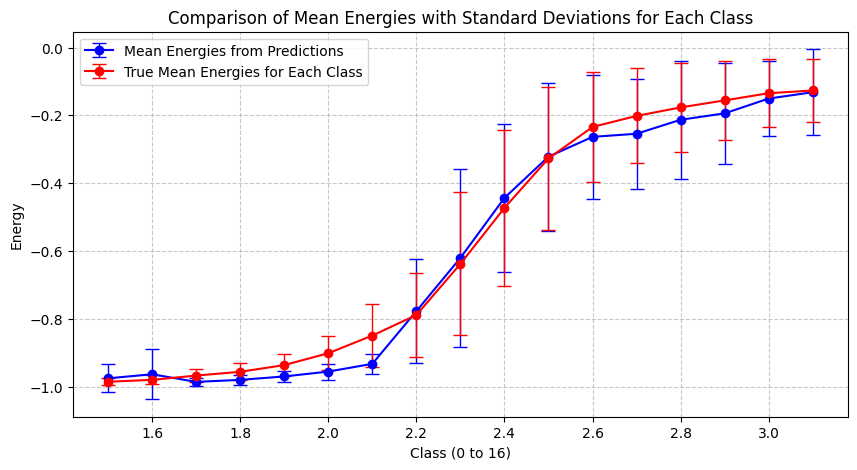

In [173]:
def Magnetization_Op(Lattice,L):
    "calculate <m> and <m^2> of a lattice configuration"
    return -abs(sum(sum(Lattice))/L**2)

energy_values = []
for mat in predictions_np:
    energy = Magnetization_Op(mat, 20)
    energy_values.append(energy)

energy_values = np.array(energy_values)
print(energy_values)
mean_values = np.zeros(17) # plot

import numpy as np

def calculate_means(energy_values):
    # Convert input to numpy array if it isn't already
    energy_array = np.array(energy_values)

    # Calculate how many complete groups of 17 we have
    n_complete_groups = len(energy_array) // 17

    # Reshape the array to handle complete groups
    # -1 tells numpy to calculate the appropriate number of rows
    reshaped_values = energy_array[:n_complete_groups * 17].reshape(-1, 17)

    # Calculate means along the vertical axis (axis=0)
    mean_values = np.mean(reshaped_values, axis=0)

    return mean_values

mean_values_real = calculate_means(energy_values)
import numpy as np
import matplotlib.pyplot as plt

def calculate_means_and_stds(energy_values):
    energy_array = np.array(energy_values)
    n_complete_groups = len(energy_array) // 17
    reshaped_values = energy_array[:n_complete_groups * 17].reshape(-1, 17)

    # Calculate both means and standard deviations
    mean_values = np.mean(reshaped_values, axis=0)
    std_values = np.std(reshaped_values, axis=0)

    return mean_values, std_values

# Calculate means and standard deviations for predictions
mean_values_real, std_values_real = calculate_means_and_stds(energy_values)

# Calculate means and standard deviations for true values
true_mean_energies = []
true_std_energies = []

for i in range(17):
    images_temp = tr_img_data[np.where(tr_lbl_data==i)[0], :, :, 0]
    energies = [Magnetization_Op(mat, 20) for mat in images_temp]
    true_mean_energies.append(np.mean(energies))
    true_std_energies.append(np.std(energies))

# Convert to numpy arrays
true_mean_energies = np.array(true_mean_energies)
true_std_energies = np.array(true_std_energies)

# Create the plot with error bars
plt.figure(figsize=(10, 5))

# Plot predicted values with error bars
plt.errorbar([1.5+i*0.1 for i in  np.arange(17)], mean_values_real, yerr=std_values_real,
             fmt='bo-', label="Mean Energies from Predictions",
             capsize=5, capthick=1, elinewidth=1)

# Plot true values with error bars
plt.errorbar([1.5+i*0.1 for i in  np.arange(17)], true_mean_energies, yerr=true_std_energies,
             fmt='ro-', label="True Mean Energies for Each Class",
             capsize=5, capthick=1, elinewidth=1)

#plt.figure(figsize = (10,5))
# Labels and title
plt.xlabel('Class (0 to 16)')
plt.ylabel('Energy')
plt.title('Comparison of Mean Energies with Standard Deviations for Each Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))

# Plot true correlation functions
for i in range(17):
    plt.errorbar(distances, true_mean_corrs[i], yerr=true_std_corrs[i],
                fmt='ro-', label=f'True Class {i}', capsize=3, alpha=0.3)

# Plot predicted correlations
plt.errorbar(distances, pred_mean_corrs, yerr=pred_std_corrs,
            fmt='bo-', label='Predictions', capsize=3, linewidth=2)

plt.yscale('log')
plt.xlabel('Distance')
plt.ylabel('Correlation Function')
plt.title('Correlation Functions: Predicted vs True Classes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

## Simulation Data
Below I plot simulation samples for the same set of temperatures. This shows that the GAN does an excellent job generating configurations for different temperatures.

Side note: The fact the at low temperatures there is varaition between being mostly purple vs mostly yellow is irrelevant. What matters is that it is mostly one color with only a few fluctuating spins.

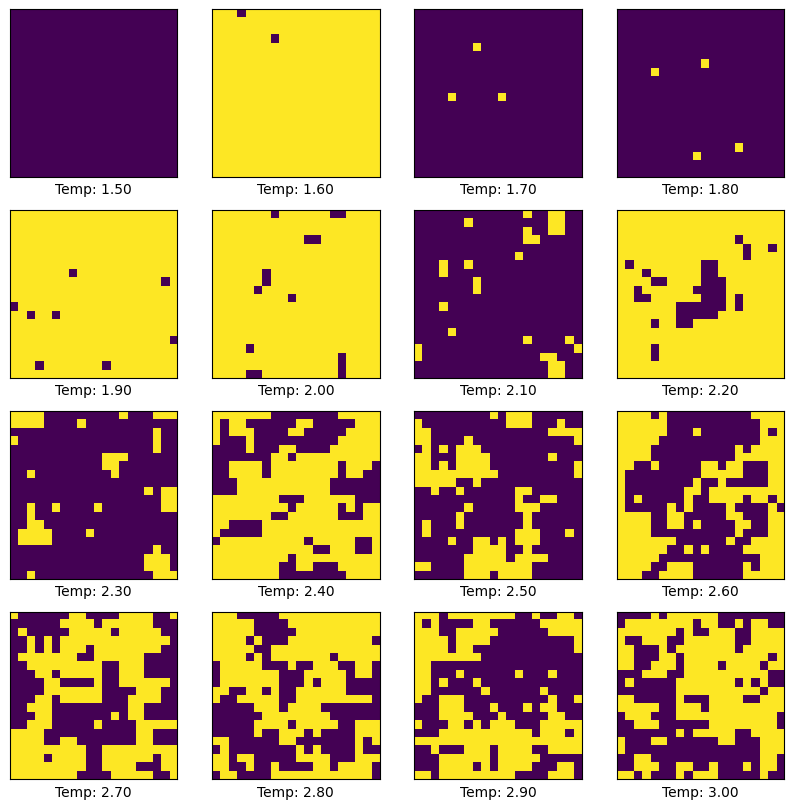

In [56]:
#np.where(tr_lbl_data==0)[0][0]

fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tr_img_data[np.where(tr_lbl_data==i)[0][1], :, :, 0])
    #plt.axis('off')
    temp = 1.5+i*0.1
    plt.xlabel(f'Temp: {temp:.2f}')

#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()

## Final Note
Improvement can be made, but these are excellent results so far. The next step will be to do some statistical analysis of the generated configurations to see how it compares to the simulations. Specifically, we know from theory how the spin-spin correlation function and correlation length should scale with temperature. It will be intersting to see where these statistical properties are upheld in the generated configurations. More to come!

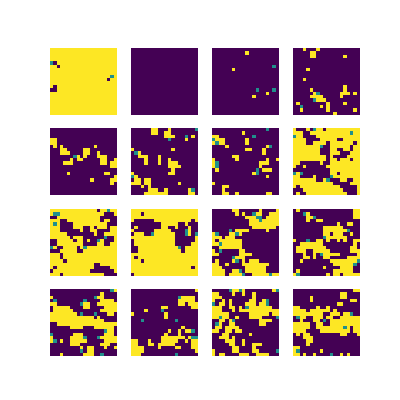

In [57]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

In [58]:
with imageio.get_writer('c_dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


# this is a hack to display the gif inside the notebook
os.system('cp c_dcgan.gif c_dcgan.gif.png')

<ipython-input-58-492bdcee6e0c>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-58-492bdcee6e0c>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


0

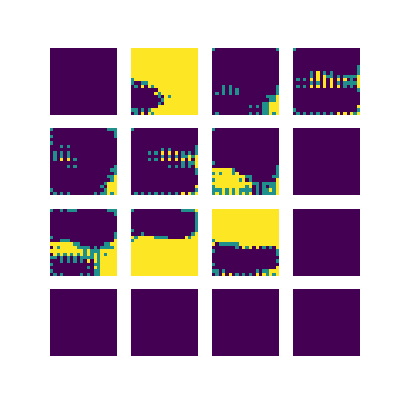

In [60]:
display.Image(filename="c_dcgan.gif.png")